In [ ]:
import os
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from paths import *
from sklearn.manifold import TSNE
import umap.umap_ as umap
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow import keras
import joblib
from sklearn.preprocessing import StandardScaler
from data_utility import get_processed_global_data
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings("ignore", message="`distplot` is a deprecated function")
warnings.filterwarnings("ignore", message="DeprecationWarning")

In [38]:
sample = "serum"


In [ ]:
_, analyte_columns_selected = get_processed_global_data(sample)

modelData = joblib.load(os.path.join(OUTPUT_PATH, "patient_classification", "dnn_models", sample, "data", "data_used_for_talos_optimized_dnn_models_for_global_compound_{}_sample.joblib".format(sample)))




In [40]:
SAMPLE_DIR = os.path.join(OUTPUT_PATH, "patient_classification", "dnn_models", sample)
MODEL_DIR = os.path.join(SAMPLE_DIR, "models")
SUMMARY_DIR = os.path.join(SAMPLE_DIR, "summary")
MODEL_DATA_DIR = os.path.join(SAMPLE_DIR, "data")

NITER = 1000
lr = 0.001
batch_size = 32

In [41]:
modelIndex_vs_auc = []
for model_index in range(NITER):
    summary_df = pd.read_csv(os.path.join(SUMMARY_DIR, "talos_for_global_compounds_{}_sample_index_{}.csv".format(sample, model_index+1)))
    summary_df = summary_df.sort_values('val_auc', ascending=False)
    best_params = summary_df.iloc[0].to_dict()
    modelIndex_vs_auc.append((model_index+1 , best_params["val_auc"]))


In [42]:
modelIndex_vs_auc_df = pd.DataFrame(modelIndex_vs_auc, columns = ["modelIndex", "val_auc"])
modelIndex_vs_auc_df.sort_values("val_auc", ascending=False, inplace=True)
# selectedModelIndex = modelIndex_vs_auc_df[modelIndex_vs_auc_df.val_auc == modelIndex_vs_auc_df.val_auc.max()].modelIndex.values[0]
# print("Selected model index = {}, with a val AUC of {}".format(selectedModelIndex, modelIndex_vs_auc_df.val_auc.max()))


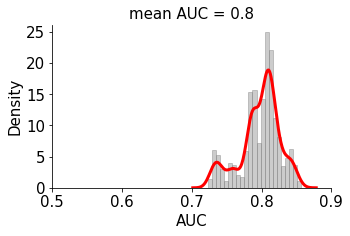

In [43]:
FIGSIZE = (5,3)
fontsize = 15
modelIndex_vs_auc_df
fig, axes = plt.subplots(figsize=FIGSIZE)

if sample == "serum":
    color = "red"
else:
    color = "red"
sns.distplot(modelIndex_vs_auc_df["val_auc"], hist=True, kde=True, ax=axes, 
             kde_kws={'color': color, 'lw': 3},
             hist_kws={'color': 'gray', 'edgecolor': 'gray', 'linewidth': 1})

# Set the title and axis labels
mean_auc = round(np.mean(modelIndex_vs_auc_df["val_auc"]), 2)
axes.set_title(f"mean AUC = {mean_auc}", fontsize=fontsize)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
plt.xlabel('AUC',fontsize=fontsize)
plt.ylabel('Density',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
if sample == "serum":
#     axes.set_xticks([0.7, 0.75, 0.8, 0.85, 0.9])
    axes.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9])
else:
    axes.set_xticks([0.6, 0.65, 0.7, 0.75, 0.8])
    axes.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9])

# Show the plot
plt.show()

# print('Saving the figure ...')
# fig_filename = os.path.join(OUTPUT_PATH, "figures", "patient_classification", "AUC_distribution_of_dnn_models_{}_sample_extended_axis.svg".format(sample))
# fig.savefig(fig_filename, format='svg', bbox_inches='tight')


In [44]:
sel = 3
selectedModelIndex = modelIndex_vs_auc_df.iloc[sel]["modelIndex"].astype(int)
selectedModel_score = modelIndex_vs_auc_df.iloc[sel]["val_auc"]
selectedModel = load_model(os.path.join(MODEL_DIR, "talos_best_dnn_model_for_global_compounds_{}_sample_index_{}.h5".format(sample, selectedModelIndex)))
selectedModel.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='binary_crossentropy', metrics=['AUC'])
selectedModel.summary()
print("val auc for the selected model = ",selectedModel_score)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              1207000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 2,209,001
Trainable params: 2,209,001
Non-trainable params: 0
_________________________________________________________________
val auc for the selected model =  0.8536000251770021


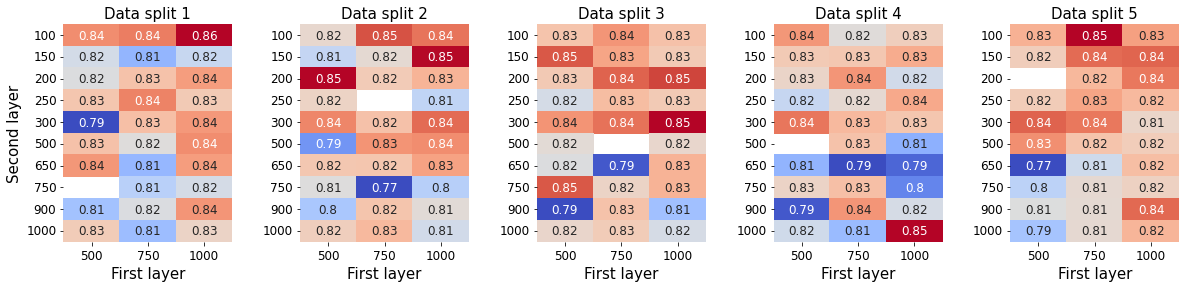

In [45]:
FIG_SIZE = (20, 4)
FONTSIZE = 12
LABELSIZE = 15
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=FIG_SIZE, sharey=False)

for i, ax in enumerate(axes.flat):
    sel_for_summary_plot = i
    selectedModelIndex_for_summary_plot = modelIndex_vs_auc_df.iloc[sel_for_summary_plot]["modelIndex"].astype(int)
    summary_df_for_summary_plot = pd.read_csv(os.path.join(SUMMARY_DIR, "talos_for_global_compounds_{}_sample_index_{}.csv".format(sample, selectedModelIndex_for_summary_plot)))
    summary_df_for_summary_plot = summary_df_for_summary_plot[["first_neuron", "second_neuron", "val_auc"]]
    heatmap_df = summary_df_for_summary_plot.pivot_table(index='second_neuron', columns='first_neuron', values='val_auc')
    sns.heatmap(heatmap_df, annot=True, cmap='coolwarm', annot_kws={"fontsize": FONTSIZE}, cbar=None, ax=ax)
    ax.set_title("Data split {}".format(i+1), fontsize=LABELSIZE)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=FONTSIZE)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=FONTSIZE)
    ax.set_xlabel('First layer', fontsize=LABELSIZE)        
    if i==0:
        ax.set_ylabel('Second layer', fontsize=LABELSIZE)
    else:
        ax.set_ylabel(None)
        
# Add some white space between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.5)

# Create a common colorbar for all subplots
# cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
# fig.colorbar(axes[0].collections[0], cax=cbar_ax)

plt.show()

# print('Saving the figure ...')
# fig_filename = os.path.join(OUTPUT_PATH, "figures", "patient_classification", "dnn_talos_optimization_{}_sample.svg".format(sample))
# fig.savefig(fig_filename, format='svg', bbox_inches='tight')


In [46]:
for item in modelData:
    if item["model_index"] == selectedModelIndex:
        train_data = item["train"] 
        test_data = item["test"]
        break

In [47]:
X_train = train_data[analyte_columns_selected].values
X_test = test_data[analyte_columns_selected].values
y_test = test_data.Disease_label.values

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

selectedModel.evaluate(X_test_norm, y_test, batch_size=batch_size)

7/7 [==============================] - 0s 2ms/step - loss: 1.3111 - auc: 0.8710


[1.4279227256774902, 0.8542000651359558]

In [48]:
last_layer_model = Sequential()
for layer in selectedModel.layers[:-1]:
    last_layer_model.add(layer)
last_layer_model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss="binary_crossentropy")

X_test_norm_latent_matrix = last_layer_model.predict(X_test_norm)


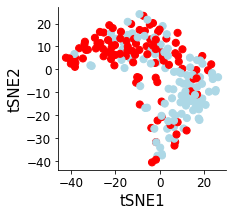

Saving the figure ...


In [33]:
# serum: 
    # (selected random state options are 29, 30, 42, 43, 62, 69). 
    # model sel = 3
    # tsne = TSNE(n_components=2, perplexity=13, random_state=29) 

# feces:
    # model sel = 15
    # selected random state options are 10, 20, 38
    # tsne = TSNE(n_components=2, perplexity=11, random_state=10)

tsne = TSNE(n_components=2, perplexity=11, random_state=10)
X_test_tsne = tsne.fit_transform(X_test_norm_latent_matrix)

fontsize = 15
FIGSIZE = (3, 3)
# Define custom colors for labels
colors = ['lightblue', 'red']

# Create a color map with the custom colors
cmap = matplotlib.colors.ListedColormap(colors)

# Plot the scatter plot with the custom color map
fig, ax = plt.subplots(figsize=FIGSIZE)
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test, cmap=cmap, s=50)
# plt.colorbar()

# Set xticks and yticks size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('tSNE1',fontsize=fontsize)
plt.ylabel('tSNE2',fontsize=fontsize)

plt.show()

print('Saving the figure ...')
fig_filename = os.path.join(OUTPUT_PATH, "figures", "patient_classification", "patient_tSNE_dnn_model_global_compounds_{}_sample.svg".format(sample))
fig.savefig(fig_filename, format='svg', bbox_inches='tight')



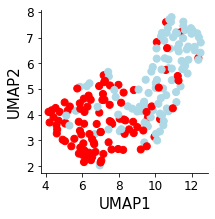

Saving the figure ...


In [49]:
# Compute the UMAP embedding

# serum:
    # umap_embed = umap.UMAP(n_neighbors=15, min_dist=0.2, n_components=2, random_state=16).fit_transform(X_test_norm_latent_matrix)

# feces:
#     umap_embed = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=12).fit_transform(X_test_norm_latent_matrix)

umap_embed = umap.UMAP(n_neighbors=15, min_dist=0.2, n_components=2, random_state=16).fit_transform(X_test_norm_latent_matrix)
fontsize = 15
FIGSIZE = (3, 3)
# Define custom colors for labels
colors = ['lightblue', 'red']

# Create a color map with the custom colors
cmap = matplotlib.colors.ListedColormap(colors)

# Plot the scatter plot with the custom color map
fig, ax = plt.subplots(figsize=FIGSIZE)
plt.scatter(umap_embed[:, 0], umap_embed[:, 1], c=y_test, cmap=cmap, s=50)
# plt.colorbar()

# Set xticks and yticks size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('UMAP1',fontsize=fontsize)
plt.ylabel('UMAP2',fontsize=fontsize)


# Add legend
# legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='MS',
#                               markerfacecolor='red', markersize=10),
#                    plt.Line2D([0], [0], marker='o', color='w', label='Control',
#                               markerfacecolor='lightblue', markersize=10)]
# ax.legend(handles=legend_elements, bbox_to_anchor=(1.5, 0.5), loc='center', fontsize=fontsize)

plt.show()

print('Saving the figure ...')
fig_filename = os.path.join(OUTPUT_PATH, "figures", "patient_classification", "patient_UMAP_dnn_model_global_compounds_{}_sample.svg".format(sample))
fig.savefig(fig_filename, format='svg', bbox_inches='tight')

# print('Saving the figure ...')
# fig_filename = os.path.join(OUTPUT_PATH, "figures", "patient_classification", "patient_UMAP_dnn_model_global_compounds_{}_sample_with_legend.svg".format(sample))
# fig.savefig(fig_filename, format='svg', bbox_inches='tight')


In [409]:
# from sklearn.cluster import KMeans

# def get_mean_distance(X_test_tsne):
#     # Apply KMeans clustering to the t-SNE embeddings
#     kmeans = KMeans(n_clusters=2, random_state=42)
#     y_pred = kmeans.fit_predict(X_test_tsne)
#     # Compute distance between cluster means
#     mean_dist = np.abs(kmeans.cluster_centers_[0] - kmeans.cluster_centers_[1]).mean()
#     return mean_dist

# perplexity_arr = np.arange(5, 50)
# random_state = 42
# perplexity_dist_list = []
# for perplexity in tqdm(perplexity_arr):
#     tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
#     X_test_tsne = tsne.fit_transform(X_test_norm_latent_matrix)
#     mean_dist = get_mean_distance(X_test_tsne)
#     perplexity_dist_list.append((perplexity, mean_dist))

# perplexity_dist_df = pd.DataFrame(perplexity_dist_list, columns=["perplexity", "mean_dist"])

# perplexity_dist_df.sort_values("mean_dist", ascending=False, inplace=True)
# perplexity_dist_df
